<a href="https://colab.research.google.com/github/sripriyavutty/smartknower-major-project/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importing Libraries

In [ ]:
!pip install vaderSentiment
!pip install pyngrok
!pip install streamlit

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from termcolor import colored
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import pickle
from pyngrok import ngrok

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Gathering Data

Imported Dataset from Kaggle [Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset)

In [ ]:
data = pd.read_csv('/content/twitter_sentiment_data.csv')

In [ ]:
data

,tweetid,tweet
0,7.929270e+17,@tiniebeany climate change is an interesting h...
1,7.931240e+17,RT @NatGeoChannel: Watch #BeforeTheFlood right...
2,7.931240e+17,Fabulous! Leonardo #DiCaprio's film on #climat...
3,7.931250e+17,RT @Mick_Fanning: Just watched this amazing do...
4,7.931250e+17,"RT @cnalive: Pranita Biswasi, a Lutheran from ..."
...,...,...
43938,7.913070e+17,"Dear @realDonaldTrump,\nYeah right. Human Medi..."
43939,7.913170e+17,What will your respective parties do to preven...
43940,7.913580e+17,RT @MikkiL: UN Poll Shows Climate Change Is th...
43941,7.913900e+17,RT @taehbeingextra: i still can$q$t believe th...


# 2. Data Preprocessing

- Remove @user mentions
- Remove non-alphabetic characters + spaces + apostrophe
- Remove links
- Remove single characters
- Remove stopwords
- Lemmatize words
- Stem words

In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")

In [ ]:
def expand_tweet(tweet):
	expanded_tweet = []
	for word in tweet:
		if re.search("n't", word):
			expanded_tweet.append(word.split("n't")[0])
			expanded_tweet.append("not")
		else:
			expanded_tweet.append(word)
	return expanded_tweet

In [ ]:
def clean_tweet(data, wordNetLemmatizer, porterStemmer):
	data['Clean_tweet'] = data['tweet']
	print(colored("Removing user handles starting with @", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("@[\w]*","")
	print(colored("Removing numbers and special characters", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.replace("[^a-zA-Z' ]","")
	print(colored("Removing urls", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))"), "")
	print(colored("Removing single characters", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].replace(re.compile(r"(^| ).( |$)"), " ")
	print(colored("Tokenizing", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].str.split()
	print(colored("Removing stopwords", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [word for word in tweet if word not in STOPWORDS])
	print(colored("Expanding not words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: expand_tweet(tweet))
	print(colored("Lemmatizing the words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [wordNetLemmatizer.lemmatize(word) for word in tweet])
	print(colored("Stemming the words", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: [porterStemmer.stem(word) for word in tweet])
	print(colored("Combining words back to tweets", "yellow"))
	data['Clean_tweet'] = data['Clean_tweet'].apply(lambda tweet: ' '.join(tweet))
	return data

In [ ]:
wordNetLemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

In [ ]:
data = clean_tweet(data, wordNetLemmatizer, porterStemmer)
data

Removing user handles starting with @
Removing numbers and special characters
Removing urls
Removing single characters
Tokenizing
Removing stopwords
Expanding not words
Lemmatizing the words
Stemming the words
Combining words back to tweets


,tweetid,tweet,Clean_tweet
0,7.929270e+17,@tiniebeany climate change is an interesting h...,climat chang interest hustl global warm planet...
1,7.931240e+17,RT @NatGeoChannel: Watch #BeforeTheFlood right...,RT watch beforetheflood right travel world tac...
2,7.931240e+17,Fabulous! Leonardo #DiCaprio's film on #climat...,fabul leonardo dicaprio' film climat chang bri...
3,7.931250e+17,RT @Mick_Fanning: Just watched this amazing do...,RT just watch amaz documentari leonardodicapri...
4,7.931250e+17,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",RT pranita biswasi lutheran odisha give testim...
...,...,...,...
43938,7.913070e+17,"Dear @realDonaldTrump,\nYeah right. Human Medi...",dear yeah right human mediat climat chang chin...
43939,7.913170e+17,What will your respective parties do to preven...,what respect parti prevent climat chang global...
43940,7.913580e+17,RT @MikkiL: UN Poll Shows Climate Change Is th...,RT UN poll show climat chang Is lowest all glo...
43941,7.913900e+17,RT @taehbeingextra: i still can$q$t believe th...,RT still canqt believ gif taehyung save human ...


# 3. Sentimental Analysis 

In [ ]:
vs=SentimentIntensityAnalyzer()
data['score'] = data['Clean_tweet'].apply(lambda x: vs.polarity_scores(x)['compound'])

In [ ]:
conditions = [
    (data['score'] >= 0.05),
    (data['score'] > -0.05) & (data['score'] < 0.05),
    (data['score'] <= -0.05)
    ]

# create a list of the values we want to assign for each condition
values = ['Positive', 'Neutral', 'Negative']

# create a new column and use np.select to assign values to it using our lists as arguments
data['tier'] = np.select(conditions, values)

# display updated data
data

,tweetid,tweet,Clean_tweet,score,tier
0,7.929270e+17,@tiniebeany climate change is an interesting h...,climat chang interest hustl global warm planet...,0.5574,Positive
1,7.931240e+17,RT @NatGeoChannel: Watch #BeforeTheFlood right...,RT watch beforetheflood right travel world tac...,0.0000,Neutral
2,7.931240e+17,Fabulous! Leonardo #DiCaprio's film on #climat...,fabul leonardo dicaprio' film climat chang bri...,0.5859,Positive
3,7.931250e+17,RT @Mick_Fanning: Just watched this amazing do...,RT just watch amaz documentari leonardodicapri...,0.0000,Neutral
4,7.931250e+17,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",RT pranita biswasi lutheran odisha give testim...,-0.5574,Negative
...,...,...,...,...,...
43938,7.913070e+17,"Dear @realDonaldTrump,\nYeah right. Human Medi...",dear yeah right human mediat climat chang chin...,0.5859,Positive
43939,7.913170e+17,What will your respective parties do to preven...,what respect parti prevent climat chang global...,0.4939,Positive
43940,7.913580e+17,RT @MikkiL: UN Poll Shows Climate Change Is th...,RT UN poll show climat chang Is lowest all glo...,-0.3818,Negative
43941,7.913900e+17,RT @taehbeingextra: i still can$q$t believe th...,RT still canqt believ gif taehyung save human ...,0.4404,Positive


# 4. TFIDF Vectorization and SVM Model Creation

In [ ]:
x = data.iloc[:,2].values
y = data.iloc[:,-1].values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 0,stratify = y)

In [ ]:
svm_model = Pipeline([('tfidf',TfidfVectorizer()),('model',SVC())])

In [ ]:
svm_model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', d

In [ ]:
y_pred = svm_model.predict(x_test)
y_pred

array(['Positive', 'Positive', 'Neutral', ..., 'Positive', 'Positive',
       'Neutral'], dtype=object)

# 5. Evaluation

In [ ]:
acc = accuracy_score(y_test,y_pred)
print ("Accuracy Score for Random Forest : ",acc)

Accuracy Score for Random Forest :  0.889327163771524


Confusion matrix:
[[3594  379  343]
 [  75 4206  107]
 [ 242  313 3924]]


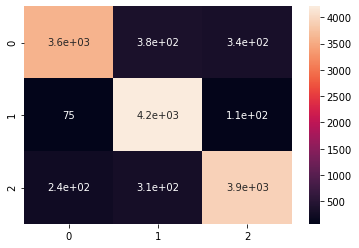

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
sns.heatmap(cm,annot=True)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.92      0.83      0.87      4316
     Neutral       0.86      0.96      0.91      4388
    Positive       0.90      0.88      0.89      4479

    accuracy                           0.89     13183
   macro avg       0.89      0.89      0.89     13183
weighted avg       0.89      0.89      0.89     13183



In [ ]:
svm_model.predict(["RT @ABCPolitics: .@realDonaldTrump vows to cancel 'billions' in climate change funds to UN, adds 'I'm an environmentalist' https://t.co/P1g54edcb"])


array(['Negative'], dtype=object)

# 6A. Web - App using ngrok and pickle

In [ ]:
pickle.dump(svm_model,open('svm_model.sav', 'wb'))

In [ ]:
model = pickle.load(open('svm_model.sav', 'rb'))


In [ ]:
model.predict(['RT @ABCPolitics: .@realDonaldTrump vows to cancel ''billions'' in climate change funds to UN, adds ''I''m an environmentalist'])

array(['Negative'], dtype=object)

In [ ]:
%%writefile app.py
import streamlit as st
import pickle

st.title("Twitter Climate Change Sentiment")

filename = 'svm_model.sav'
model = pickle.load(open(filename, 'rb'))

select = st.text_input('Enter your message')

if(st.markdown(
    '<span class="badge badge-pill badge-success"> Model Prediction </span>',
    unsafe_allow_html=True
)):
  op = model.predict([select])
  ans=op[0]
  if ans == 'Positive':
    st.success("Positive 🙂")
  if ans == 'Negative':
    st.error("Negative 😠")
  if ans== 'Neutral':
    st.warning("Neutral 😐")

Writing app.py


In [ ]:
!nohup streamlit run app.py & 

url = ngrok.connect(port = 8501)
url #generates our URL

nohup: appending output to 'nohup.out'


<NgrokTunnel: "http://1e127bff65c3.ngrok.io" -> "http://localhost:80">

# 6B. Deployed web app on Heroku using Streamlit

Link : https://smartknower-major-project.herokuapp.com/